In [ ]:
# ============================
# Install kagglehub + libraries
# ============================
!pip install kagglehub tensorflow matplotlib scikit-learn

# ============================
# Import required libraries
# ============================
import os
import kagglehub
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

print("All imports loaded successfully.")


All imports loaded successfully.


In [ ]:
# ============================
# Download HAM10000 metadata
# ============================
# This will download the dataset locally in Colab
dataset_path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

metadata_path = os.path.join(dataset_path, "HAM10000_metadata.csv")
df = pd.read_csv(metadata_path)

df.head()


Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# ============================
# ADDITIONAL PREPROCESSING
# ============================

# 1️⃣ Remove duplicate images (same lesion_id + image_id)
df = df.drop_duplicates(subset=["lesion_id", "image_id"])

# 2️⃣ Remove corrupted / missing image files
img_dir_1 = os.path.join(dataset_path, "HAM10000_images_part_1")
img_dir_2 = os.path.join(dataset_path, "HAM10000_images_part_2")

def get_valid_path(image_id):
    file1 = os.path.join(img_dir_1, f"{image_id}.jpg")
    file2 = os.path.join(img_dir_2, f"{image_id}.jpg")
    if os.path.exists(file1):
        return file1
    elif os.path.exists(file2):
        return file2
    else:
        return None

df["path"] = df["image_id"].apply(get_valid_path)

# Keep only rows where image file exists
df = df[df["path"].notnull()]

# 3️⃣ Optional: Check class imbalance
print("Class distribution before binary conversion:")
print(df["dx"].value_counts())

# 4️⃣ Compute class weights (for later use in model.fit)
from sklearn.utils import class_weight
df["label_numeric"] = df["dx"].apply(lambda x: 1 if x in ["mel", "akiec", "bcc"] else 0)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df["label_numeric"]),
    y=df["label_numeric"]
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


In [ ]:
# ============================
# Map dx → binary labels
# ============================

benign = ["nv", "bkl", "df", "vasc"]
malignant = ["mel", "akiec", "bcc"]

df["label"] = df["dx"].apply(lambda x: 1 if x in malignant else 0)

df["label"].value_counts()


,count
label,
0,8061
1,1954


In [ ]:
# ============================
# Assign image file paths
# ============================

# There are two folders in the dataset
img_dir_1 = os.path.join(dataset_path, "HAM10000_images_part_1")
img_dir_2 = os.path.join(dataset_path, "HAM10000_images_part_2")

def get_image_path(image_id):
    file = f"{image_id}.jpg"
    if os.path.exists(os.path.join(img_dir_1, file)):
        return os.path.join(img_dir_1, file)
    return os.path.join(img_dir_2, file)

df["path"] = df["image_id"].apply(get_image_path)

df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...


In [ ]:
# ============================
# Train, validation, test split
# ============================

train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df["label"], random_state=42)

len(train_df), len(val_df), len(test_df)


(7235, 1277, 1503)

In [ ]:
# ============================
# Image size and batch size
# ============================
IMG_SIZE = 128
BATCH = 32

# ============================
# Data augmentation for training
# ============================
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

# ============================
# Convert labels to strings for binary mode
# ============================
train_df["label"] = train_df["label"].astype(str)
val_df["label"] = val_df["label"].astype(str)
test_df["label"] = test_df["label"].astype(str)

# ============================
# Flow from dataframe
# ============================
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col="path",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode="binary"
)

val_data = val_gen.flow_from_dataframe(
    val_df,
    x_col="path",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode="binary"
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col="path",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode="binary"
)


Found 7235 validated image filenames belonging to 2 classes.
Found 1277 validated image filenames belonging to 2 classes.
Found 1503 validated image filenames belonging to 2 classes.


In [ ]:
# ============================
# SIMPLE CNN FROM SCRATCH
# ============================

cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ============================
# Train the CNN
# ============================

history_cnn = cnn.fit(
    train_data,
    validation_data=val_data,
    epochs=3,
    class_weight=class_weights
)


Epoch 1/3
227/227 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.8060 - loss: 0.4534 - val_accuracy: 0.8050 - val_loss: 0.4240
Epoch 2/3
227/227 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.8016 - loss: 0.4387 - val_accuracy: 0.8050 - val_loss: 0.4370
Epoch 3/3
227/227 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.8091 - loss: 0.4251 - val_accuracy: 0.8050 - val_loss: 0.4134


In [ ]:
# ============================
# Evaluate CNN
# ============================

cnn_test_loss, cnn_test_acc = cnn.evaluate(test_data)
print("CNN Test Accuracy:", cnn_test_acc)


47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 747ms/step - accuracy: 0.8117 - loss: 0.4148
CNN Test Accuracy: 0.8050565719604492


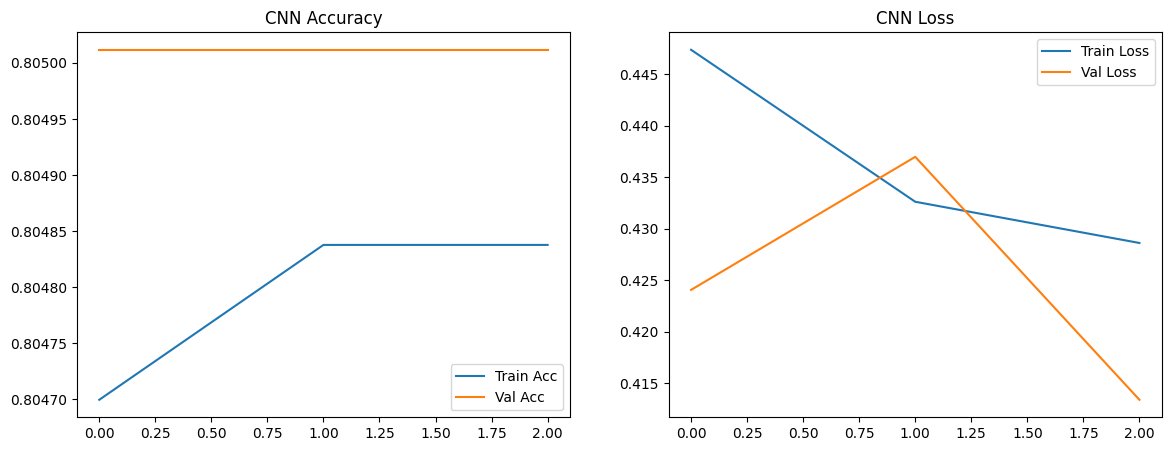

In [ ]:
# ============================
# Plot accuracy & loss curves
# ============================

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Train Acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val Acc')
plt.title("CNN Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title("CNN Loss")
plt.legend()

plt.show()


In [ ]:
# ============================
# TRANSFER LEARNING: MobileNetV2
# ============================

base = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base.trainable = False  # freeze weights

transfer_model = tf.keras.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

transfer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

transfer_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# ============================
# Train Transfer Learning model
# ============================

history_transfer = transfer_model.fit(
    train_data,
    validation_data=val_data,
    epochs=3,
    class_weight=class_weights
)


Epoch 1/3
227/227 ━━━━━━━━━━━━━━━━━━━━ 231s 991ms/step - accuracy: 0.8002 - loss: 0.4750 - val_accuracy: 0.8152 - val_loss: 0.3810
Epoch 2/3
227/227 ━━━━━━━━━━━━━━━━━━━━ 211s 930ms/step - accuracy: 0.8212 - loss: 0.3695 - val_accuracy: 0.8254 - val_loss: 0.3737
Epoch 3/3
227/227 ━━━━━━━━━━━━━━━━━━━━ 204s 898ms/step - accuracy: 0.8468 - loss: 0.3445 - val_accuracy: 0.8254 - val_loss: 0.3826


In [ ]:
# ============================
# Evaluate MobileNetV2
# ============================

tl_test_loss, tl_test_acc = transfer_model.evaluate(test_data)
print("Transfer Learning Test Accuracy:", tl_test_acc)


47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 770ms/step - accuracy: 0.8272 - loss: 0.3673
Transfer Learning Test Accuracy: 0.8256819844245911


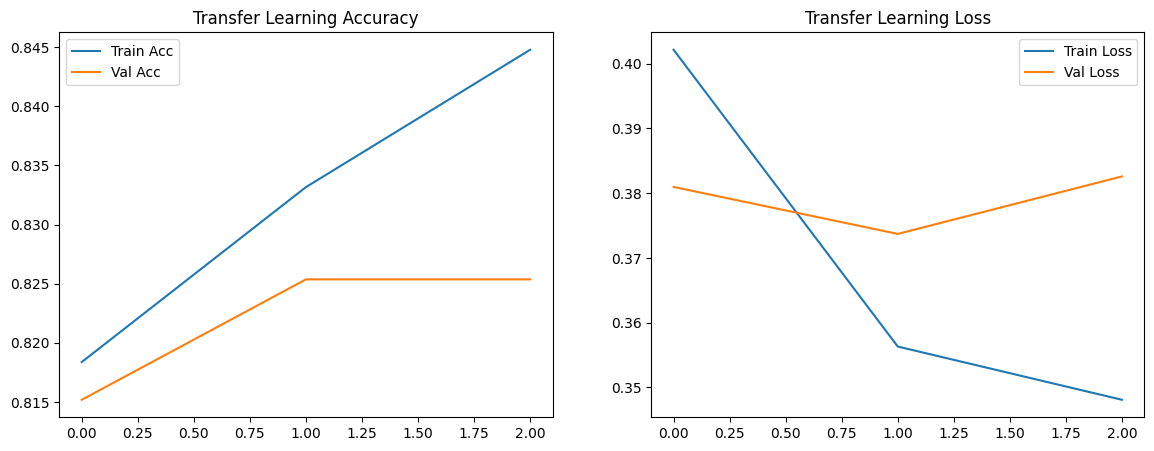

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_transfer.history['accuracy'], label='Train Acc')
plt.plot(history_transfer.history['val_accuracy'], label='Val Acc')
plt.title("Transfer Learning Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_transfer.history['loss'], label='Train Loss')
plt.plot(history_transfer.history['val_loss'], label='Val Loss')
plt.title("Transfer Learning Loss")
plt.legend()

plt.show()


In [ ]:
print("======================================")
print(" FINAL RESULTS ")
print("======================================")

print(f"CNN from Scratch Accuracy:       {cnn_test_acc:.4f}")
print(f"Transfer Learning Accuracy:      {tl_test_acc:.4f}")

if tl_test_acc > cnn_test_acc:
    print("\nTransfer learning performed better.")
else:
    print("\nCNN from scratch performed better.")


 FINAL RESULTS 
CNN from Scratch Accuracy:       0.8051
Transfer Learning Accuracy:      0.8257

Transfer learning performed better.
